In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from joblib import load
import numpy as np
from sklearn.svm import NuSVR, SVR
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from utils import nb_utils
import sklearn.preprocessing as sklp

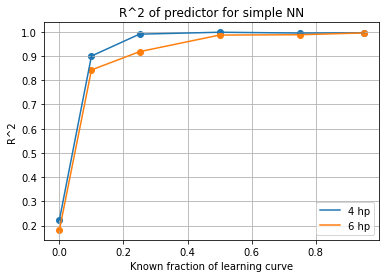

In [60]:
'''
r2 for different known fractions of the learning curve. Using 4hp vs 6hp search space
'''
lc = [0.0, 0.1, 0.25, 0.5, 0.75, 0.95]
#4hp_300
r2 = [0.22403961538598205, 0.8999997566529759, 0.9902491879059602, 0.9981281161265539,0.9948304924468403, 0.9957560886696417]
plt.scatter(lc,r2)
plt.plot(lc, r2,label="4 hp")
#6hp_300
r2 = [0.18199650749836238, 0.8425353570944493, 0.9178920638307584, 0.9865299976933071, 0.9877538295056862, 0.9954100184701985]
plt.scatter(lc,r2,)
plt.plot(lc, r2, label ="6 hp")
plt.xlabel("Known fraction of learning curve")
plt.ylabel("R^2")
plt.legend(loc="lower right")
plt.title("R^2 of predictor for simple NN")
plt.grid()
plt.show()

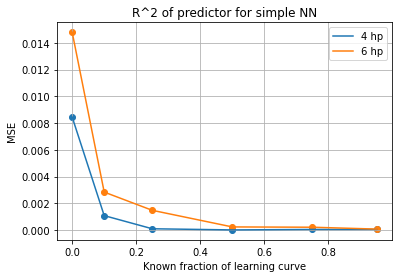

In [34]:
'''
mse of the performance predictor for different known fractions of the learning curve. Using 4hp vs 6hp search space
'''
lc = [0.0, 0.1, 0.25, 0.5, 0.75, 0.95]
#4hp_300
mse = [0.008452663555809713, 0.0010885464511665637, 0.00010614186071653187, 2.0376275889295854e-05, 5.627235407560785e-05, 5.782874930618936e-05]
plt.scatter(lc,mse)
plt.plot(lc, mse,label="4 hp")
#6hp_300
mse = [0.014791127486088108, 0.0028472734274574973, 0.001484674530893162, 0.00024356438961756308, 0.00022143508023885782, 8.299598056538616e-05]
plt.scatter(lc,mse)
plt.plot(lc, mse, label ="6 hp")
plt.xlabel("Known fraction of learning curve")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.title("R^2 of predictor for simple NN")
plt.grid()
plt.show()

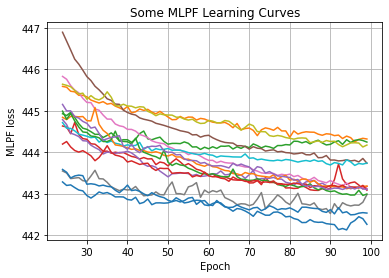

In [51]:
'''
Shows that learning curves may intersect => good to use performance prediction instead of only acc at given point
'''
df = pd.read_csv('../data/mlpf/delphes_trainings_processed.csv')
df = df.loc[df['loss_99'].isin(np.sort(df.loss_99.to_numpy())[:15])]

for i in range(df.shape[0]):
    loss = df.iloc[i][["loss_"+str(x)for x in range(24,100)]].values.tolist()
    #plt.scatter(lc,loss,s=1)
    plt.plot([x for x in range(24,100)],loss)

plt.xlabel("Epoch")
plt.ylabel("MLPF loss")
plt.title("Some MLPF Learning Curves")
plt.grid()

plt.show()

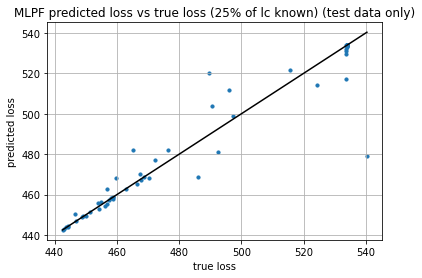

In [2]:
'''
True vs predicted value
'''
df_info = nb_utils.get_df_info('mlpf')
known_curve = 0.25

df = pd.read_csv(df_info['df_path'])
#remove MLPF outlier
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)# 

hps = nb_utils.get_hps(df_info, df)
curve = nb_utils.get_curve(df_info,known_curve,df)
target = nb_utils.get_target(df_info,df)

difs1, difs2 = nb_utils.finite_difs(curve)
X = np.append(np.append(np.append(hps,curve,1),difs1,1),difs2,1)
y = target

_, X, _, y = train_test_split(X, y, test_size=0.2, random_state=0)

x_scaler = load("x_scaler_mlpf.joblib")
y_scaler = load("y_scaler_mlpf.joblib")
X = x_scaler.transform(X)
y = y_scaler.transform(y.reshape(-1, 1))
model = load("model_mlpf.joblib")
y_pred = model.predict(X)

x = y_scaler.inverse_transform(y.reshape(-1, 1))
y = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
plt.scatter(x,y,s=10)
plt.plot([x.min(),x.max()],[x.min(),x.max()],'k')

plt.xlabel("true loss")
plt.ylabel("predicted loss")
plt.grid()
plt.title("MLPF predicted loss vs true loss (25% of lc known) (test data only)")
plt.savefig("../results/mlpf_loss_true_vs_predicted_test.png",dpi=300)
plt.show()

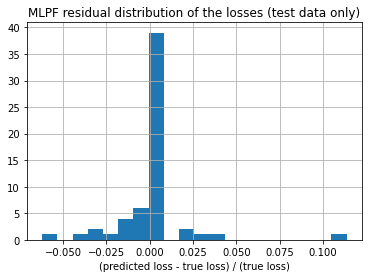

In [3]:
hist_data = ((x - y)/x)
plt.grid()
plt.hist(hist_data, bins=20)
plt.title("MLPF residual distribution of the losses (test data only)")
plt.xlabel("(predicted loss - true loss) / (true loss)")
plt.savefig("../results/mlpf_residual_dist_test.png",dpi=300)

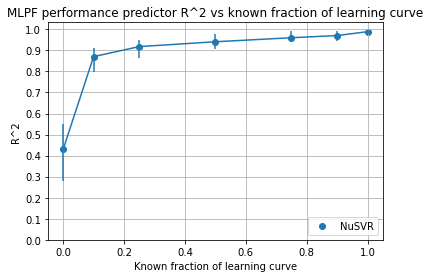

In [4]:
'''
R^2 vs known frac of learning curve
'''

lc = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.]
df_info = nb_utils.get_df_info('mlpf')
known_curve = 0.25

df = pd.read_csv(df_info['df_path'])
#remove mlpf outlier
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

hps = nb_utils.get_hps(df_info, df)
target = nb_utils.get_target(df_info,df)

Models = [NuSVR]
names = ['NuSVR']

for i in range(len(Models)):
	r2 = []
	yerr = [[],[]]
	for known_curve in lc:
		curve = nb_utils.get_curve(df_info, known_curve, df)
		difs1, difs2 = nb_utils.finite_difs(curve)
		X = np.append(np.append(np.append(hps,curve,1),difs1,1),difs2,1)
		y = target	
		x_scaler = MinMaxScaler()
		y_scaler = MinMaxScaler()
		X = x_scaler.fit_transform(X)
		y = y_scaler.fit_transform(y.reshape(-1, 1))
		#instatiate and train predictor
		model = Models[i]()
		cvs = cross_val_score(model, X, y.ravel(), cv = 5, scoring='r2')
		r2.append(cvs.mean())
		yerr[0].append(cvs.mean()-cvs.min())
		yerr[1].append(cvs.max()-cvs.mean())

	plt.scatter(lc,r2,label = names[i])
	#plt.plot(lc, r2)
	plt.errorbar(lc, r2, yerr=yerr)

plt.xlabel("Known fraction of learning curve")
plt.ylabel("R^2")
plt.title("MLPF performance predictor R^2 vs known fraction of learning curve")
plt.grid()
plt.yticks(np.arange(0., 1.+0.1, 0.1))
plt.legend(loc='lower right')
plt.savefig("../results/mlpf_r2_vs_lc.png",dpi=300)
plt.show()


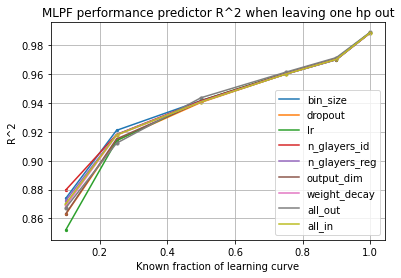

In [5]:
'''
Compare the importance of each hp
'''
lc = [0.1, 0.25, 0.5, 0.75, 0.9, 1.]
df_info = nb_utils.get_df_info('mlpf')
known_curve = 0.25

df = pd.read_csv(df_info['df_path'])
#remove mlpf outlier
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

min_hp_idx = df_info['min_hp_idx']
max_hp_idx = df_info['max_hp_idx']
cols = df.columns[min_hp_idx:max_hp_idx+1]

target = nb_utils.get_target(df_info,df)

plt.xlabel("Known fraction of learning curve")
plt.ylabel("R^2")
plt.title("MLPF performance predictor R^2 when leaving one hp out")
plt.grid()
#plt.yticks(np.arange(0., 1.+0.1, 0.1))

# ONE OUT
for col in cols:
	r2 = []
	yerr = [[],[]]
	hps = df[df.drop(col,axis=1).columns[min_hp_idx:max_hp_idx]].to_numpy()
	for known_curve in lc:
		curve = nb_utils.get_curve(df_info,known_curve,df)
		difs1, difs2 = nb_utils.finite_difs(curve)
		X = np.append(np.append(np.append(hps,curve,1),difs1,1),difs2,1)
		y = target	
		x_scaler = MinMaxScaler()
		y_scaler = MinMaxScaler()
		X = x_scaler.fit_transform(X)
		y = y_scaler.fit_transform(y.reshape(-1, 1))
		#instatiate and train predictor
		model = NuSVR()
		cvs = cross_val_score(model, X, y.ravel(), cv = 5, scoring='r2')
		r2.append(cvs.mean())
		yerr[0].append(cvs.mean()-cvs.min())
		yerr[1].append(cvs.max()-cvs.mean())

	plt.scatter(lc,r2,s=5)
	plt.plot(lc, r2,label=col)
	#plt.errorbar(lc, r2, yerr=yerr)

# ALL OUT
r2 = []
yerr = [[],[]]
for known_curve in lc[:]:
		curve = nb_utils.get_curve(df_info,known_curve,df)
		difs1, difs2 = nb_utils.finite_difs(curve)
		X = np.append(np.append(curve,difs1,1),difs2,1)
		y = target	
		x_scaler = MinMaxScaler()
		y_scaler = MinMaxScaler()
		X = x_scaler.fit_transform(X)
		y = y_scaler.fit_transform(y.reshape(-1, 1))
		#instatiate and train predictor
		model = NuSVR()
		cvs = cross_val_score(model, X, y.ravel(), cv = 5, scoring='r2')
		r2.append(cvs.mean())
		yerr[0].append(cvs.mean()-cvs.min())
		yerr[1].append(cvs.max()-cvs.mean())
plt.scatter(lc[:],r2,s=10)
plt.plot(lc[:], r2,label='all_out')

# ALL IN
hps = nb_utils.get_hps(df_info, df)
r2 = []
yerr = [[],[]]
for known_curve in lc[:]:
		curve = nb_utils.get_curve(df_info,known_curve,df)
		difs1, difs2 = nb_utils.finite_difs(curve)
		X = np.append(np.append(np.append(hps,curve,1),difs1,1),difs2,1)
		y = target	
		x_scaler = MinMaxScaler()
		y_scaler = MinMaxScaler()
		X = x_scaler.fit_transform(X)
		y = y_scaler.fit_transform(y.reshape(-1, 1))
		#instatiate and train predictor
		model = NuSVR()
		cvs = cross_val_score(model, X, y.ravel(), cv = 5, scoring='r2')
		r2.append(cvs.mean())
		yerr[0].append(cvs.mean()-cvs.min())
		yerr[1].append(cvs.max()-cvs.mean())
plt.scatter(lc[:],r2,s=10)
plt.plot(lc[:], r2,label='all_in')

plt.legend(loc="lower right")
#plt.savefig("../results/mlpf_r2_hps_out_no_points.png",dpi=300)
plt.show()

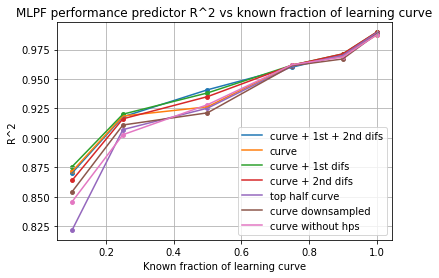

In [7]:
'''
Compare the importance of different learning curve information
'''
lc = [0.1, 0.25, 0.5, 0.75, 0.9, 1.]
df_info = nb_utils.get_df_info('mlpf')
known_curve = 0.25

df = pd.read_csv(df_info['df_path'])
#remove mlpf outlier
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

hps = nb_utils.get_hps(df_info,df)
target = nb_utils.get_target(df_info,df)

plt.xlabel("Known fraction of learning curve")
plt.ylabel("R^2")
plt.title("MLPF performance predictor R^2 vs known fraction of learning curve")
plt.grid()

for i in range(7):
	r2 = []
	yerr = [[],[]]
	for known_curve in lc:	
		curve = nb_utils.get_curve(df_info, known_curve, df)
		difs1, difs2 = nb_utils.finite_difs(curve)
		if i == 0:
			# All learning curve information with finite diffs and hps
			X = np.append(np.append(np.append(hps,curve,1),difs1,1),difs2,1)
			label = "curve + 1st + 2nd difs"
		elif i == 1:
			# Learning curve and hps
			X = np.append(hps,curve,1)
			label = "curve"
		elif i == 2:
			# Learning curve with only 1st order diffs and hps
			X = np.append(np.append(hps,curve,1),difs1,1)
			label = "curve + 1st difs"
		elif i == 3:
			# Learning curve with only 2nd order diffs and hps
			X = np.append(np.append(hps,curve,1),difs2,1)
			label = "curve + 2nd difs"
		elif i == 4:
			# Last 50% of known learning curve and hps
			X = np.append(hps,curve[:,int(curve.shape[1]/2):],1)
			label = "top half curve"
		elif i == 5:
			# downsampled learning curve and hps
			X = np.append(hps,curve[:,[i for i in range(0,curve.shape[1],2)]],1)
			label = "curve downsampled"
		elif i == 6:
			# learning curve without hps
			X = curve
			label = "curve without hps"
		y = target	
		x_scaler = MinMaxScaler()
		y_scaler = MinMaxScaler()
		X = x_scaler.fit_transform(X)
		y = y_scaler.fit_transform(y.reshape(-1, 1))
		#instatiate and train predictor
		model = NuSVR()
		cvs = cross_val_score(model, X, y.ravel(), cv = 5, scoring='r2')
		r2.append(cvs.mean())
		yerr[0].append(cvs.mean()-cvs.min())
		yerr[1].append(cvs.max()-cvs.mean())
	plt.scatter(lc,r2,s=15)
	plt.plot(lc, r2,label=label)
	#plt.errorbar(lc, r2, yerr=yerr)
plt.legend(loc="lower right")
plt.savefig("../results/mlpf_curve_info.png",dpi=300)
plt.show()

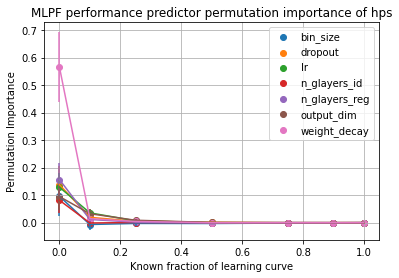

In [13]:
'''
Permutation feature importance (~1 min run)
'''
lc = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.]

from sklearn.inspection import permutation_importance
df_info = nb_utils.get_df_info('mlpf')
known_curve = 0.25

df = pd.read_csv(df_info['df_path'])
#remove mlpf outlier
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)
hps = nb_utils.get_hps(df_info, df)
target = nb_utils.get_target(df_info,df)

imps = []
yerr = []
min_hp_idx = df_info['min_hp_idx']
max_hp_idx = df_info['max_hp_idx']
hp_names = df.columns[min_hp_idx:max_hp_idx+1]
for _ in hp_names:
	imps.append([])
	yerr.append([])

for known_curve in lc:
	
	curve = nb_utils.get_curve(df_info,known_curve,df)
	difs1, difs2 = nb_utils.finite_difs(curve)
	X = np.append(np.append(np.append(hps,curve,1),difs1,1),difs2,1)
	y = target	
	x_scaler = MinMaxScaler()
	y_scaler = MinMaxScaler()
	X = x_scaler.fit_transform(X)
	y = y_scaler.fit_transform(y.reshape(-1, 1))
	#instatiate and train predictor
	model = NuSVR()
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
	model.fit(X_train,y_train.ravel())
	r = permutation_importance(model, X_test, y_test,n_repeats=30, random_state=0)
	for i in range(len(hp_names)):
	#if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
		imps[i].append(r.importances_mean[i])
		yerr[i].append(r.importances_std[i])
		#print(f"{df.columns[i]+' ':<8}"f"{r.importances_mean[i]:.3f}"f" +/- {r.importances_std[i]:.3f}")
	
for i in range(len(hp_names)):
	plt.scatter(lc,imps[i],label=hp_names[i])
	plt.errorbar(lc, imps[i], yerr=yerr[i])

plt.xlabel("Known fraction of learning curve")
plt.ylabel("Permutation Importance")
plt.title("MLPF performance predictor permutation importance of hps")
plt.grid()
plt.legend(loc="upper right")
plt.savefig("../results/mlpf_perm_importance.png",dpi=300)
plt.show()

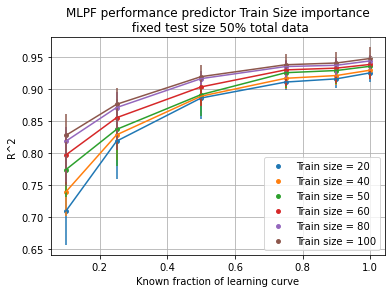

In [2]:
'''
Compare the importance of training set
'''
lc = [0.1, 0.25, 0.5, 0.75, 0.9, 1.]

from sklearn.inspection import permutation_importance
df_info = nb_utils.get_df_info('mlpf')
known_curve = 0.25

df = pd.read_csv(df_info['df_path'])
#remove mlpf outlier
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

hps = nb_utils.get_hps(df_info, df)
target = nb_utils.get_target(df_info,df)

plt.xlabel("Known fraction of learning curve")
plt.ylabel("R^2")
plt.title("MLPF performance predictor Train Size importance\n fixed test size 50% total data")
plt.grid()
#plt.yticks(np.arange(0., 1.+0.1, 0.1))

t_sizes = [20, 40, 50, 60, 80, 100]

for t_size in t_sizes:
	r2 = []
	yerr = [[],[]]
	for known_curve in lc:
		curve = nb_utils.get_curve(df_info, known_curve, df)
		difs1, difs2 = nb_utils.finite_difs(curve)
		X = np.append(np.append(np.append(hps,curve,1),difs1,1),difs2,1)
		y = target	
		x_scaler = MinMaxScaler()
		y_scaler = MinMaxScaler()
		X = x_scaler.fit_transform(X)
		y = y_scaler.fit_transform(y.reshape(-1, 1))
		#instatiate and train predictor
		model = SVR()
		cvs, _ = nb_utils.small_train_r2_cv(model, X, y, reps = 5, train_size = t_size, rs = 0)
		r2.append(cvs.mean())
		yerr[0].append(cvs.mean()-cvs.min())
		yerr[1].append(cvs.max()-cvs.mean())

	plt.scatter(lc,r2,s=15,label="Train size = " + str(t_size))
	#plt.plot(lc, r2)
	plt.errorbar(lc, r2, yerr=yerr)

plt.legend(loc="lower right")
plt.savefig("../results/mlpf_train_size.png",dpi=300)
plt.show()

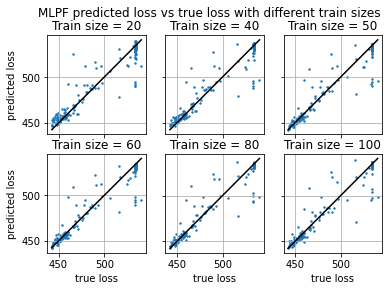

In [3]:
'''
True vs predicted value
'''
t_sizes = [20, 40, 50, 60, 80, 100]

from sklearn.inspection import permutation_importance
df_info = nb_utils.get_df_info('mlpf')
known_curve = 0.25

df = pd.read_csv(df_info['df_path'])
#remove mlpf outlier
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

fig, axs = plt.subplots(2,3)
fig.suptitle("MLPF predicted loss vs true loss with different train sizes")

for ax in axs.flat:
    ax.set(xlabel='true loss', ylabel='predicted loss')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


hps = nb_utils.get_hps(df_info, df)
target = nb_utils.get_target(df_info,df)
curve = nb_utils.get_curve(df_info, known_curve, df)

difs1, difs2 = nb_utils.finite_difs(curve)

for i in range(len(t_sizes)): 
    t_size = t_sizes[i] 
    X = np.append(np.append(np.append(hps,curve,1),difs1,1),difs2,1)
    y = target

    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X = x_scaler.fit_transform(X)
    y = y_scaler.fit_transform(y.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

    X_train = X_train[:t_size]
    y_train = y_train[:t_size]

    #instatiate and train predictor
    model = NuSVR()
    model.fit(X_train,y_train.ravel())
    y_pred = model.predict(X_test)
    x = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    y = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    axs.flat[i].scatter(x,y,s=2)

    '''
    model = SVR()
    model.fit(X_train,y_train.ravel())
    y_pred = model.predict(X_test)
    x = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    y = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    axs.flat[i].scatter(x,y,s=2)
    '''

    axs.flat[i].plot([x.min(),x.max()],[x.min(),x.max()],'k')
    axs.flat[i].set_title('Train size = ' + str(t_size))

plt.savefig("../results/mlpf_loss_dif_tsizes.png",dpi=300)
plt.show()

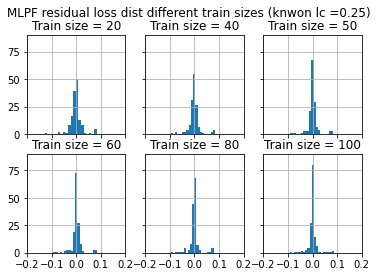

In [4]:
'''
Histogram loss distribution
'''
t_sizes = [20, 40, 50, 60, 80, 100]

from sklearn.inspection import permutation_importance
df_info = nb_utils.get_df_info('mlpf')
known_curve = 0.25

df = pd.read_csv(df_info['df_path'])
#remove mlpf outlier
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

fig, axs = plt.subplots(2,3)
fig.suptitle("MLPF residual loss dist different train sizes (knwon lc =" + str(known_curve)+ ")")
for ax in axs.flat:
    ax.grid()
    ax.set_xlim([-0.2,0.2])
    ax.set_ylim([0.,90])
    ax.set_xticks(np.arange(-0.2, 0.2+0.1, 0.1))
    ax.label_outer()

hps = nb_utils.get_hps(df_info, df)
target = nb_utils.get_target(df_info,df)
curve = nb_utils.get_curve(df_info, known_curve, df)
difs1, difs2 = nb_utils.finite_difs(curve)

for i in range(len(t_sizes)): 
    t_size = t_sizes[i] 
    X = np.append(np.append(np.append(hps,curve,1),difs1,1),difs2,1)
    y = target

    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X = x_scaler.fit_transform(X)
    y = y_scaler.fit_transform(y.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

    X_train = X_train[:t_size]
    y_train = y_train[:t_size]

    #instatiate and train predictor
    model = NuSVR()
    model.fit(X_train,y_train.ravel())
    y_pred = model.predict(X_test)
    x = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    y = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    
    hist_data = ((x - y)/x)
    axs.flat[i].hist(hist_data, bins=20)
    axs.flat[i].set_title('Train size = ' + str(t_size))

plt.savefig("../results/mlpf_hist_loss_dif_tsizes.png",dpi=300)
plt.show()

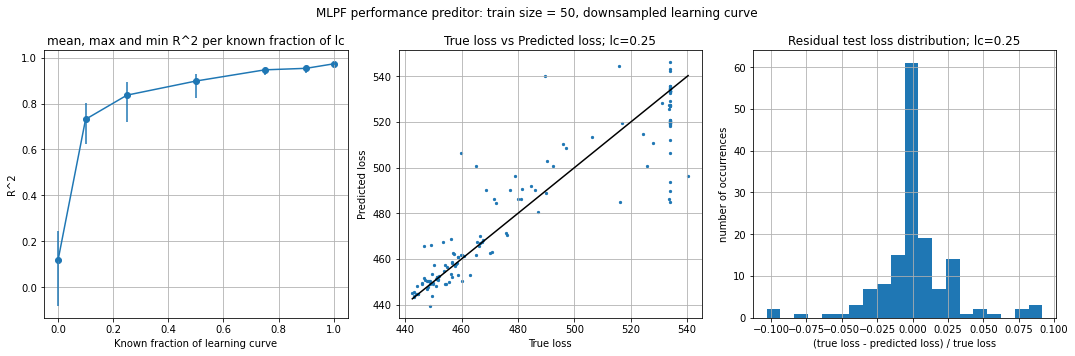

In [6]:
'''
MLPF 50 train set, downsampled lc
'''

lc = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.]

Models = [NuSVR]
names = ['NuSVR']
t_size = 50
known_curve_last_plots = 0.25

df_info = nb_utils.get_df_info('mlpf')

df = pd.read_csv(df_info['df_path'])
#drop mlpf outlier
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)


fig, axs = plt.subplots(1,3,figsize=(15, 5))
fig.suptitle("MLPF performance preditor: train size = 50, downsampled learning curve")

for ax in axs.flat:
    ax.grid()

hps = nb_utils.get_hps(df_info, df)
target = nb_utils.get_target(df_info,df)

'''
First plot: learning curve
'''
for i in range(len(Models)):
	r2 = []
	yerr = [[],[]]
	for known_curve in lc:
		curve = nb_utils.get_curve(df_info, known_curve, df)
		X = X = np.append(hps,curve[:,[i for i in range(0,curve.shape[1],2)]],1)
		y = target	
		x_scaler = MinMaxScaler()
		y_scaler = MinMaxScaler()
		X = x_scaler.fit_transform(X)
		y = y_scaler.fit_transform(y.reshape(-1, 1))
		#instatiate and train predictor
		model = Models[i]()
		cvs, rss = nb_utils.small_train_r2_cv(model, X, y, reps = 5, train_size = t_size, rs = 0)
		r2.append(cvs.mean())
		yerr[0].append(cvs.mean()-cvs.min())
		yerr[1].append(cvs.max()-cvs.mean())
		if(known_curve == 0.25):
			saved_rs = rss[np.argsort(cvs)[len(cvs)//2]]

	axs.flat[0].scatter(lc,r2,label = names[i])
	#plt.plot(lc, r2)
	axs.flat[0].errorbar(lc, r2, yerr=yerr)

axs.flat[0].set_xlabel("Known fraction of learning curve")
axs.flat[0].set_ylabel("R^2")
axs.flat[0].set_title('mean, max and min R^2 per known fraction of lc')

'''
Second and third plots: True vs predicted loss
'''
curve = nb_utils.get_curve(df_info, known_curve_last_plots, df)
X = np.append(hps,curve[:,[i for i in range(0,curve.shape[1],2)]],1)
y = target
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = x_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=saved_rs)

X_train = X_train[:t_size]
y_train = y_train[:t_size]

#instatiate and train predictor
model = NuSVR()
model.fit(X_train,y_train.ravel())
y_pred = model.predict(X_test)
x = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y = y_scaler.inverse_transform(y_pred.reshape(-1, 1))

'''
Second Plot: True vs predicted loss
'''
axs.flat[1].scatter(x,y,s=5)
axs.flat[1].plot([x.min(),x.max()],[x.min(),x.max()],'k')
axs.flat[1].set_title('True loss vs Predicted loss; lc='+str(known_curve_last_plots))
axs.flat[1].set_xlabel("True loss")
axs.flat[1].set_ylabel("Predicted loss")

'''
Third Plot: Hist
'''
hist_data = ((x - y)/x)
axs.flat[2].hist(hist_data, bins=20)
axs.flat[2].set_title('Residual test loss distribution; lc='+str(known_curve_last_plots))
axs.flat[2].set_xlabel("(true loss - predicted loss) / true loss")
axs.flat[2].set_ylabel("number of occurrences")


fig.tight_layout()

plt.savefig("../results/mlpf_worst_case.png",dpi=300)
plt.show()

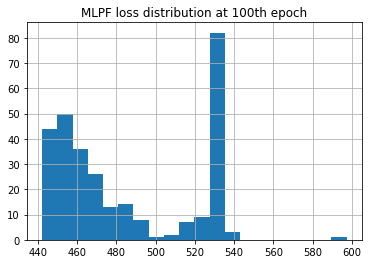

In [20]:
df = pd.read_csv('../data/mlpf/delphes_trainings_processed.csv')
plt.grid()
plt.title('MLPF loss distribution at 100th epoch')
plt.hist(df['loss_99'],bins = 20)
plt.savefig("../results/MLPF_loss_100epoch.png",dpi=300)

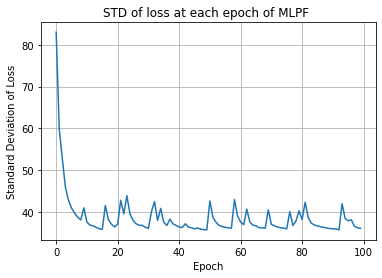

(296, 107)


In [50]:
df = pd.read_csv('../data/mlpf/delphes_trainings_processed.csv')
plt.grid()
losses = ['loss_' + str(i) for i in range(100)]
stds = []
for loss in losses:
    stds.append(df[loss].std())
#plt.scatter([i for i in range(100)],stds,s=10)
plt.plot([i for i in range(100)],stds)
plt.xlabel('Epoch')
plt.ylabel('Standard Deviation of Loss')
plt.title('STD of loss at each epoch of MLPF ')
plt.show()
#plt.savefig("../results/MLPF_loss_100epoch.png",dpi=300)
print(df.shape)

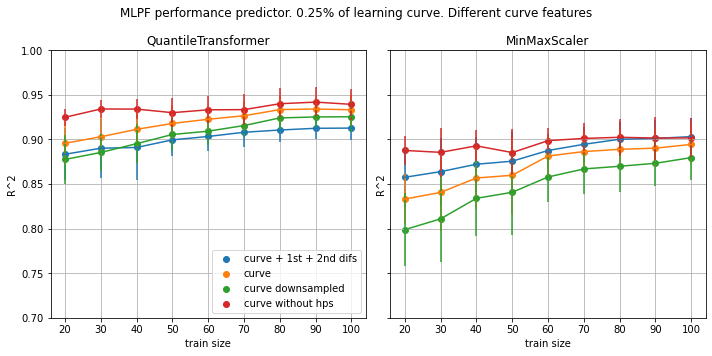

In [9]:
'''
Compare the importance of different learning curve information for different Train Sizes
'''
known_curve = 0.25

df_info = nb_utils.get_df_info('mlpf')
known_curve = 0.25

df = pd.read_csv(df_info['df_path'])
#remove mlpf outlier
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

#t_sizes = [20, 30, 40, 50, 60, 70, 80, 90, 100, 0.8*df.shape[0]]
t_sizes = [20, 30, 40, 50, 60, 70, 80, 90, 100]

hps = nb_utils.get_hps(df_info,df)
target = nb_utils.get_target(df_info,df)
curve = nb_utils.get_curve(df_info, known_curve, df)

fig, axs = plt.subplots(1,2,figsize=(10, 5))

fig.suptitle("MLPF performance predictor. 0.25% of learning curve. Different curve features")

for ax in axs.flat:
	ax.grid()
	ax.set_ylim([0.7,1.])
	ax.label_outer()
	ax.set(xlabel='train size', ylabel='R^2')

for scaler in [0,1]:
	for i in [0,1,5,6]: #select the different lines to be displayed
		r2 = []
		yerr = [[],[]]
		for t_size in t_sizes:	
			difs1, difs2 = nb_utils.finite_difs(curve)
			if i == 0:
				# All learning curve information with finite diffs and hps
				X = np.append(np.append(np.append(hps,curve,1),difs1,1),difs2,1)
				label = "curve + 1st + 2nd difs"
			elif i == 1:
				# Learning curve and hps
				X = np.append(hps,curve,1)
				label = "curve"
			elif i == 2:
				# Learning curve with only 1st order diffs and hps
				X = np.append(np.append(hps,curve,1),difs1,1)
				label = "curve + 1st difs"
			elif i == 3:
				# Learning curve with only 2nd order diffs and hps
				X = np.append(np.append(hps,curve,1),difs2,1)
				label = "curve + 2nd difs"
			elif i == 4:
				# Last 50% of known learning curve and hps
				X = np.append(hps,curve[:,int(curve.shape[1]/2):],1)
				label = "top half curve"
			elif i == 5:
				# downsampled learning curve and hps
				X = np.append(hps,curve[:,[i for i in range(0,curve.shape[1],2)]],1)
				label = "curve downsampled"
			elif i == 6:
				# learning curve without hps
				X = curve
				label = "curve without hps"
			y = target	

			#select scaler
			if scaler == 0:
				x_scaler = sklp.QuantileTransformer(n_quantiles=50, random_state=0)
				y_scaler = sklp.QuantileTransformer(n_quantiles=50, random_state=0)
				axs.flat[scaler].set_title('QuantileTransformer')
			elif scaler == 1:
				x_scaler = MinMaxScaler()
				y_scaler = MinMaxScaler()
				axs.flat[scaler].set_title('MinMaxScaler')

			X = x_scaler.fit_transform(X)
			y = y_scaler.fit_transform(y.reshape(-1, 1))
			#instatiate and train predictor
			model = NuSVR()
		
			cvs = []
			if t_size != 0.8*df.shape[0]:
				cvs, _ = nb_utils.small_train_r2_cv(model, X, y, reps = 10, train_size = t_size, rs = 0)

			else:
				for rs in range(10):
					X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
					model.fit(X_train,y_train.ravel())
					cvs.append(model.score(X_test,y_test))

			cvs = np.array(cvs)
			r2.append(cvs.mean())
			#yerr[0].append(cvs.mean()-cvs.min())
			#yerr[1].append(cvs.max()-cvs.mean())
			yerr[0].append(cvs.std())
			yerr[1].append(cvs.std())

		axs.flat[scaler].scatter(t_sizes,r2,label=label)
		#plt.plot(t_sizes, r2)
		axs.flat[scaler].errorbar(t_sizes, r2, yerr=yerr)



axs.flat[0].legend(loc="lower right")
fig.tight_layout()

#plt.savefig("../results/mlpf_scaler_curve_info.png",dpi=300)
plt.show()